Initializing model...
Model initialized.
Decoding took 0.004 seconds
Alignment took 1.28 seconds
Total took 1.28 seconds
[(0.1, 0.12, '好'), (0.22, 0.24, '被'), (0.38, 0.4, '撞'), (0.58, 0.6, '擊'), (0.7000000000000001, 0.72, '而'), (0.8, 0.8200000000000001, '不'), (0.9, 0.92, '幸'), (1.1, 1.12, '身'), (1.26, 1.28, '亡'), (1.3800000000000001, 1.42, '的'), (1.52, 1.54, '蘇'), (1.7, 1.72, '姓'), (1.9000000000000001, 1.92, '員'), (2.12, 2.14, '警'), (2.2600000000000002, 2.2800000000000002, '他'), (2.4, 2.42, '們'), (2.6, 2.62, '家'), (2.92, 2.94, '屬'), (3.24, 3.2800000000000002, '下'), (3.5, 3.52, '午'), (3.62, 3.64, '兩'), (3.88, 3.9, '點'), (4.08, 4.1, '來'), (4.24, 4.26, '到'), (4.36, 4.38, '了'), (4.5600000000000005, 4.58, '分'), (4.82, 4.84, '駐'), (5.0600000000000005, 5.08, '所'), (5.28, 5.3, '進'), (5.44, 5.48, '行'), (5.68, 5.7, '招'), (5.92, 5.94, '魂'), (6.1000000000000005, 6.12, '儀'), (6.32, 6.34, '式'), (6.82, 6.84, '同'), (7.0200000000000005, 7.04, '袍'), (7.2, 7.22, '也'), (7.3, 7.34, '在'), (7.44, 7.46, '門'),

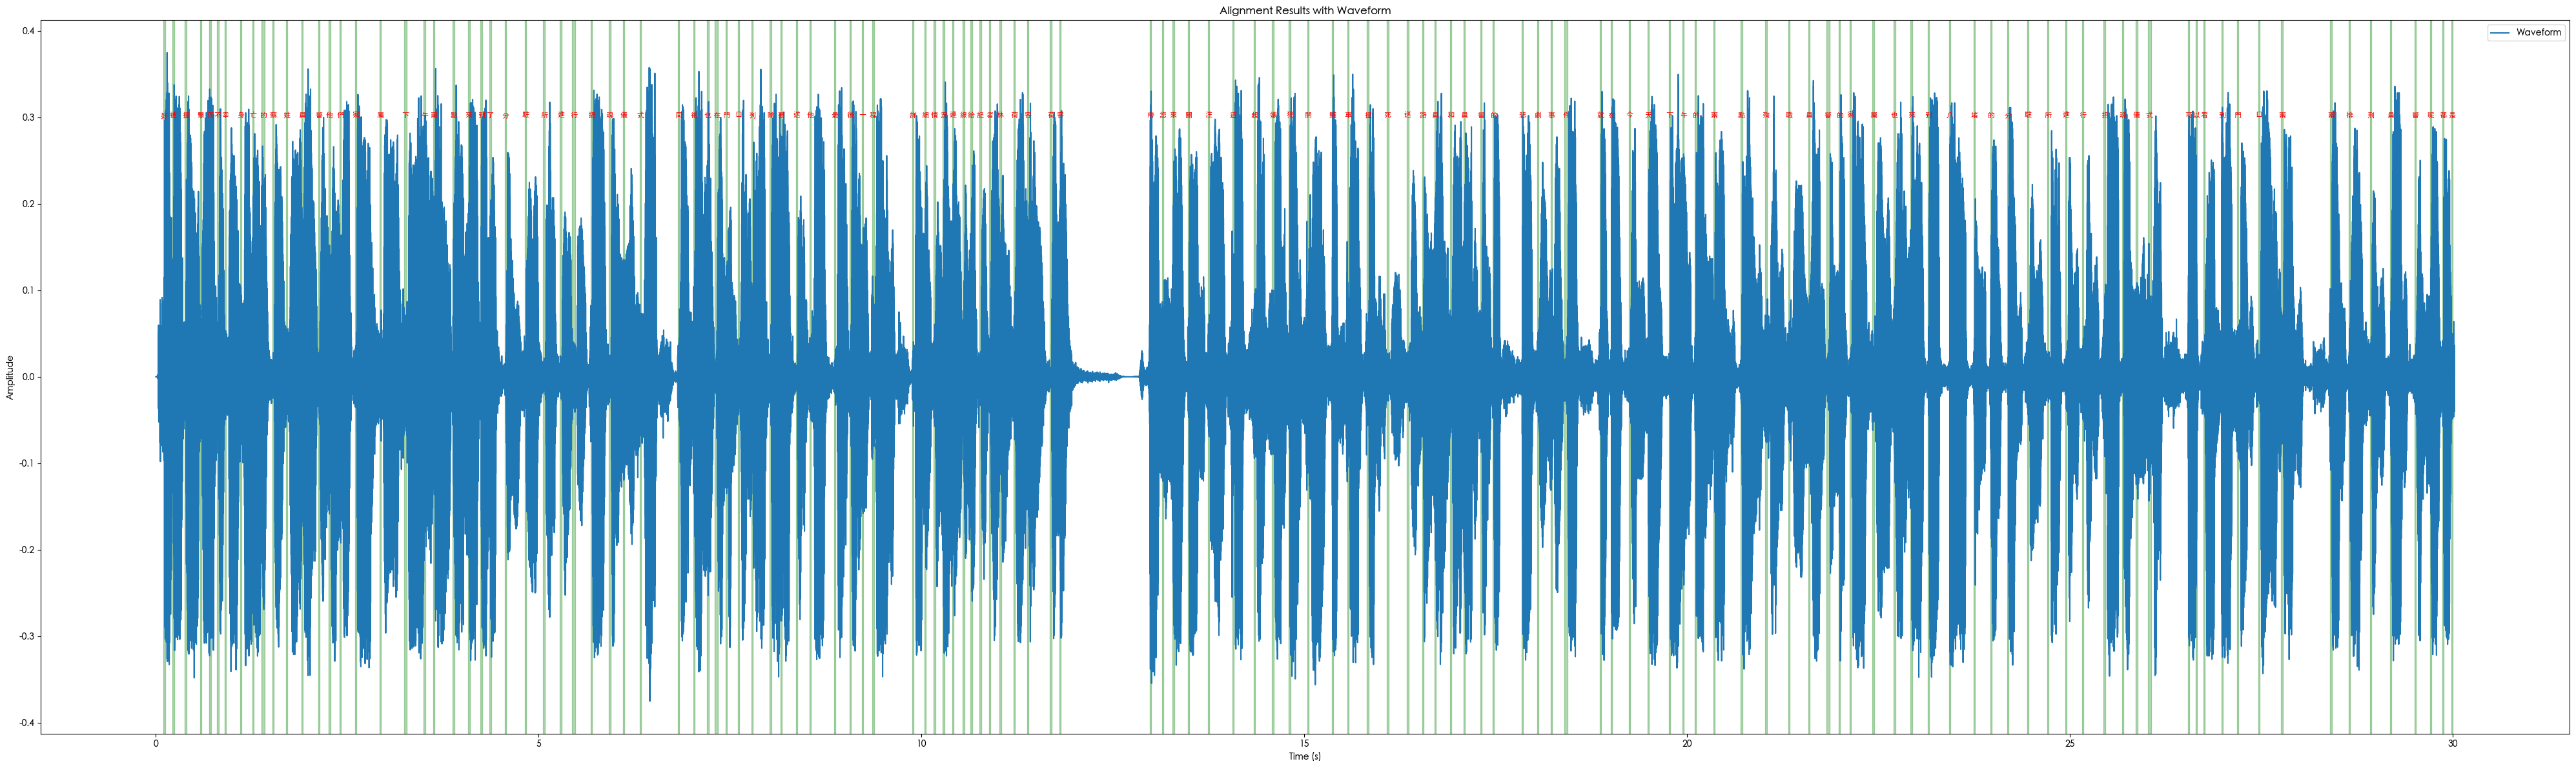

In [ ]:
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import numpy as np
import re
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import time
import opencc
import platform
from dataclasses import dataclass
import re
import base64
import io
 # 强制对齐
from torchaudio.functional import forced_align
import logging

def is_jupyter_notebook():
    try:
        from IPython import get_ipython
        if 'ipykernel' in str(type(get_ipython())):
            # 在 Jupyter Notebook 或 JupyterLab 中运行
            return True
        else:
            # 在其他环境中运行（如 IPython 终端）
            return False
    except ImportError:
        # 未安装 IPython，纯 Python 脚本
        return False

@dataclass
class SpeechSegment:
    startStr: str      # 开始时间字符串，如 "01,090"
    endStr: str        # 结束时间字符串，如 "01,981"
    text: str          # 文本内容，如 "絞豆子"
    startSeconds: float  # 开始时间转换为秒数，如 1.09
    endSeconds: float    # 结束时间转换为秒数，如 1.981
    lineNumber: int      # 行号

def initModel():
    print("Initializing model...")
    t2s = opencc.OpenCC('tw2s')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载模型和处理器
    processor = Wav2Vec2Processor.from_pretrained("ydshieh/wav2vec2-large-xlsr-53-chinese-zh-cn-gpt")
    model = Wav2Vec2ForCTC.from_pretrained("ydshieh/wav2vec2-large-xlsr-53-chinese-zh-cn-gpt").to(device)
    model.eval()
    print("Model initialized.")
    
    if is_jupyter_notebook():
        # 查找系统中的中文字体
        if platform.system() == 'Linux':
            zh_font = fm.FontProperties(fname='/usr/share/fonts/truetype/arphic/ukai.ttc')  # Linux 示例
        elif platform.system() == 'Darwin':
            zh_font = fm.FontProperties(fname='/System/Library/Fonts/STHeiti Light.ttc')  # macOS 示例
        elif platform.system() == 'Windows':
            zh_font = fm.FontProperties(fname='C:/Windows/Fonts/msyh.ttc')  # Windows 示例
        else:
            raise EnvironmentError("Unsupported platform")


        plt.rcParams['font.family'] = zh_font.get_name()
        plt.rcParams['axes.unicode_minus'] = False

    return t2s, device, processor, model

def main():
    t2s, device, processor, model = initModel()
    test(t2s, device, processor, model)

def format_time_srt(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    millis = int((seconds - int(seconds)) * 1000)
    return f"{hours:02}:{minutes:02}:{secs:02},{millis:03}"

# 生成 SRT 字幕内容
def generate_srt(segments):
    srt_content = ""
    for idx, segment in enumerate(segments, start=1):
        start_time = format_time_srt(segment.startSeconds)
        end_time = format_time_srt(segment.endSeconds)
        srt_content += f"{idx}\n{start_time} --> {end_time}\n{segment.text}\n\n"
    return srt_content

# 示例使用

def base64_to_raw_data(data_uri):
    header, base64_str = data_uri.split(',', 1)
    audio_data = base64.b64decode(base64_str)
    return audio_data

def test(t2s, device, processor, model):
    # 加载音频
    audio_path = '/Users/jon/Desktop/sample.mp3'

    # 读取 MP3 文件的二进制数据
    with open(audio_path, 'rb') as file:
        binary_data = file.read()
    # 将二进制数据转换为 base64 编码的字符串
    base64_encoded_data = base64.b64encode(binary_data).decode('utf-8')
    data_uri = f'data:audio/mp3;base64,{base64_encoded_data}'
    # Extract format from data_uri
    format_match = re.search(r'data:audio/(\w+);base64,', data_uri)
    if format_match:
        audio_format = format_match.group(1)
    else:
        raise ValueError("Invalid data URI format")

    startTotal = time.time()
    decodeTime = time.time()
    audio_data = base64_to_raw_data(data_uri)
    waveform, sample_rate = torchaudio.load(io.BytesIO(audio_data), format=audio_format)
    waveform = waveform.squeeze(0)
    print(f"Decoding took {time.time() - decodeTime:.3f} seconds")
    #srt_content = generate_srt(segments)
    #print(srt_content)

    
    #wavform = audio.get_array_of_samples()
    #sample_rate = audio.frame_rate

    #waveform, sample_rate = torchaudio.load(audio_path)
    #waveform = waveform.squeeze(0) 

    # 如果采样率不是 16kHz，重新采样
    if sample_rate != 16000:
        waveform = torchaudio.functional.resample(waveform, sample_rate, 16000)
        sample_rate = 16000

    startTime = time.time()
    transcript = "好被撞擊而不幸身亡的蘇姓員警他們家屬下午兩點來到了分駐所進行招魂儀式同袍也在門口列隊要送他最後一程詳細情況連線給記者林荷容荷容帶您來關注這起嫌犯開贓車撞死巡路員和員警的悲劇事件就在今天下午的兩點殉職員警的家屬也來到八堵的分駐所進行招魂儀式可以看到門口兩兩排刑員警呢都是"
    transcript_s = transcript

    assert len(transcript)==len(transcript_s)

    labels = processor.tokenizer.encode(transcript_s, add_special_tokens=False)

    # 准备输入
    inputs = processor(waveform.to(device), sampling_rate=sample_rate, return_tensors="pt", padding=True).to(device)
    targets = torch.tensor(labels, dtype=torch.int32).unsqueeze(0).to(device)

    # 获取发射矩阵
    with torch.no_grad():
        logits = model(inputs.input_values).logits

    emission = torch.log_softmax(logits, dim=-1)

    alignment, scores = forced_align(
        log_probs=emission,
        targets=targets,
        blank=processor.tokenizer.pad_token_id  # 通常 blank_id 为 0
    )

    # 解析对齐结果
    frame_shift = 20 / 1000  # 20ms

    alignment = alignment[0]
    words = []
    current_token = None
    start_time = 0
    textId = 0
    for idx, token_id in enumerate(alignment):
        if token_id != current_token:
            if current_token is not None and current_token != processor.tokenizer.pad_token_id:
                end_time = idx * frame_shift
                token = processor.tokenizer.convert_ids_to_tokens([current_token])[0]
                if(token != transcript_s[textId] and not(token == '|' and transcript_s[textId] == ' ')):
                    print(f"Warning: {token} != {transcript_s[textId]}")    
                words.append((start_time, end_time, transcript_s[textId]))
                textId += 1
            current_token = token_id
            start_time = idx * frame_shift

    # 处理最后一个 token
    if current_token != processor.tokenizer.pad_token_id:
        end_time = len(alignment) * frame_shift
        token = processor.tokenizer.convert_ids_to_tokens([current_token])[0]
        if(token != transcript_s[textId] and not(token == '|' and transcript_s[textId] == ' ') ):
            print(f"Warning: {token} != {transcript_s[textId]}")
        words.append((start_time, end_time, transcript_s[textId]))
        textId += 1
        
            
            #segments.append((start_time, end_time, token))
    print(f"Alignment took {time.time() - startTime:.2f} seconds")
    print(f"Total took {time.time() - startTotal:.2f} seconds")
    print(words)


    if is_jupyter_notebook():
        # 创建时间轴
        duration = waveform.shape[0] / sample_rate
        xtime = np.linspace(0, duration, waveform.shape[0])

        plt.figure(figsize=(40, 12))
        plt.plot(xtime, waveform.numpy(), label='Waveform')

        # 在波形上标注对齐结果
        for start_time, end_time, token in words:
            # 绘制对齐区间
            plt.axvspan(start_time, end_time, color='green', alpha=0.3)
            # 在区间中间位置标注文本
            plt.text((start_time + end_time) / 2, np.max(waveform.numpy()) * 0.8, token,
                    horizontalalignment='center', fontsize=8, color='red')

        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Alignment Results with Waveform')
        plt.legend()
        plt.tight_layout()

        # 显示图像
        plt.show()

if __name__ == "__main__":
    main()  # 只有当文件被直接运行时，main() 函数才会执行。